# KHANES 대사성 질환 전처리

KNHANES 2023 추출 데이터로부터 생물학적, 심리학적, 사회/행동적 (BPS) 영역을 선별하여 `docs/methods.pdf`의 연구 설계에 맞춘 모델링 준비 완료 데이터셋을 구축합니다.
구체적으로는 비흡연/비음주 성인 중 20~64세를 필터링하고, 이상치를 처리하고, 선형 보간법을 수행한 후, 간단한 탐색적 데이터 분석(EDA) 내용을 포함합니다.

## Google Colab에서 실행하기

Colab에서 실행시 필요함

In [1]:
import os
import sys

try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    import subprocess
    import sys
    packages = ['pandas', 'numpy', 'scipy', 'scikit-learn', 
                'matplotlib', 'seaborn', 'pyarrow', 'missingno']
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q'] + packages)
    
    os.makedirs('data', exist_ok=True)
    os.makedirs('src', exist_ok=True)

    if not os.path.exists('src/utils.py'):
        try:
            import urllib.request
            url = 'https://raw.githubusercontent.com/jspark2000/aicap-2025-2/main/src/utils.py'
            urllib.request.urlretrieve(url, 'src/utils.py')
        except Exception as e:
            print(f"코드 다운로드 실패: {e}")
    
    print("\n데이터 파일 업로드가 필요합니다:")
    print("   1. 다음 셀을 실행하여 khanes-2023.csv 파일을 업로드하세요.")
    print("   2. 또는 Google Drive에 데이터를 저장하고 마운트하세요.")
    
else:
    print("로컬 환경에서 실행 중입니다. Colab 설정을 건너뜁니다.")


로컬 환경에서 실행 중입니다. Colab 설정을 건너뜁니다.


In [2]:
if IN_COLAB:
    from google.colab import files
    
    print("khanes-2023.csv 파일을 업로드하세요:")
    uploaded = files.upload()

    for filename in uploaded.keys():
        if filename.endswith('.csv'):
            os.rename(filename, f'data/{filename}')
            print(f"✅ {filename} 파일이 data/ 폴더로 이동되었습니다.")
    
    # Google Drive 마운트 옵션 (선택사항)
    print("\n또는 Google Drive를 사용하려면 아래 주석을 해제하세요:")
    print("# from google.colab import drive")
    print("# drive.mount('/content/drive')")
    print("# DATA_PATH = Path('/content/drive/MyDrive/path/to/khanes-2023.csv')")
else:
    print("로컬 환경에서는 이 셀을 건너뜁니다.")


로컬 환경에서는 이 셀을 건너뜁니다.


## 전처리 코드

In [3]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from src.utils import (
    load_khanes_data,
    replace_numeric_sentinels,
    cap_iqr_outliers,
    interpolate_numeric_features,
    standardize_features,
    compute_metabolic_flag,
    filter_non_smoking_non_drinking,
)

pd.set_option("display.max_columns", 100)
sns.set_theme(style="whitegrid", context="talk")

DATA_PATH = Path("data/khanes-2023.csv")
OUTPUT_PATH_CSV = Path("data/khanes_preprocessed.csv")

In [4]:
TARGET_COLS = ["DI1_dg", "DE1_dg", "DI2_dg"]
BIO_COLS = [
    "sex",
    "age",
    "HE_ht",
    "HE_wt",
    "HE_wc",
    "HE_BMI",
    "HE_sbp",
    "HE_dbp",
    "HE_glu",
    "HE_HbA1c",
    "HE_chol",
    "HE_HDL_st2",
    "HE_TG",
    "HE_LDL_drct",
]
PSY_GAD_COLS = [
    "BP_GAD_1",
    "BP_GAD_2",
    "BP_GAD_3",
    "BP_GAD_4",
    "BP_GAD_5",
    "BP_GAD_6",
    "BP_GAD_7",
]
PSY_CORE_COLS = ["mh_stress"]
SOC_BEHAV_COLS = [
    "edu",
    "ho_incm5",
    "marri_1",
    "pa_aerobic",
    "N_EN",
    "N_PROT",
    "N_FAT",
    "N_SFA",
    "N_CHO",
    "N_TDF",
    "N_SUGAR",
    "N_NA",
    "N_K",
    "N_VITC",
    "N_VITD",
]
LIFESTYLE_COLS = ["sm_presnt", "BD1", "BD1_11", "dr_month"]
ID_COLS = ["ID", "ID_fam", "year"]

USECOLS = sorted(
    set(
        ID_COLS
        + TARGET_COLS
        + BIO_COLS
        + PSY_GAD_COLS
        + PSY_CORE_COLS
        + SOC_BEHAV_COLS
        + LIFESTYLE_COLS
    )
)
print(f"Total columns pulled: {len(USECOLS)}")

Total columns pulled: 47


In [5]:
raw_df = load_khanes_data(DATA_PATH, usecols=USECOLS, low_memory=False)
print(f"Raw shape: {raw_df.shape}")
raw_df.head()

Raw shape: (6929, 47)


,ID,ID_fam,year,sex,age,ho_incm5,edu,marri_1,DI1_dg,DI2_dg,DE1_dg,BD1,BD1_11,dr_month,BP_GAD_1,BP_GAD_2,BP_GAD_3,BP_GAD_4,BP_GAD_5,BP_GAD_6,BP_GAD_7,mh_stress,sm_presnt,pa_aerobic,HE_sbp,HE_dbp,HE_ht,HE_wt,HE_wc,HE_BMI,HE_glu,HE_HbA1c,HE_chol,HE_HDL_st2,HE_TG,HE_LDL_drct,N_EN,N_PROT,N_FAT,N_SFA,N_CHO,N_TDF,N_SUGAR,N_NA,N_K,N_VITD,N_VITC
0,YA84208301,YA842083,2023.0,1.0,75.0,2.0,1.0,1.0,1.0,1.0,0.0,1.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,142.0,88.0,159.8,58.9,90.2,23.065440,125.0,6.0,166.0,38.0,162.0,101.0,624.642550,18.927046,25.627933,9.216467,81.943318,20.930879,48.082091,501.630439,1297.868017,0.587070,29.390490
1,YA84208302,YA842083,2023.0,2.0,70.0,2.0,1.0,1.0,0.0,1.0,0.0,1.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,131.0,84.0,151.2,41.8,65.2,18.284063,105.0,5.5,218.0,67.0,74.0,139.0,922.289958,33.330471,50.315861,18.138261,77.965687,5.314416,47.560904,1923.830383,994.107616,1.174140,15.650710
2,YA84212402,YA842124,2023.0,2.0,42.0,3.0,3.0,1.0,0.0,0.0,0.0,2.0,5.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,103.0,60.5,156.7,53.5,71.8,21.787921,102.0,5.3,196.0,87.0,43.0,105.0,3521.884974,190.252617,122.484520,23.925787,414.337910,25.209885,83.408735,5362.983379,4533.091266,0.108327,35.242941
3,YA84212404,YA842124,2023.0,2.0,9.0,3.0,1.0,2.0,8.0,8.0,8.0,8.0,8.0,NaN,8.0,8.0,8.0,8.0,8.0,8.0,8.0,NaN,NaN,NaN,139.0,62.0,142.0,35.8,59.6,17.754414,NaN,NaN,NaN,NaN,NaN,NaN,3476.032477,153.000712,100.613773,24.660589,467.455665,18.917919,46.068955,2849.206185,2507.678074,1.333000,69.595766
4,YA84242702,YA842427,2023.0,1.0,43.0,5.0,4.0,1.0,0.0,0.0,0.0,2.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,131.0,95.0,185.0,79.8,86.9,23.316289,101.0,5.5,176.0,40.0,145.0,116.0,2624.110312,86.885509,50.167467,18.278104,447.247774,29.890427,108.118573,6600.858453,3505.069908,1.680265,65.171145


In [6]:
df = raw_df.copy()

# 상징값 처리: 8, 9만 처리할 컬럼들 (나머지는 모든 상징값 처리)
# - PSY_GAD_COLS: 0-3=실제값, 8-9=상징값
# - TARGET_COLS: 0-1=실제값, 8-9=상징값  
# - BD1, BD1_11: 1-6=실제값, 8-9=상징값
cols_8_9_only = PSY_GAD_COLS + TARGET_COLS + ["BD1", "BD1_11"]
column_specific_sentinels = {
    col: [8.0, 9.0] 
    for col in cols_8_9_only 
    if col in df.columns
}

df = replace_numeric_sentinels(
    df,
    columns=[col for col in df.columns if col not in ID_COLS],
    column_specific_sentinels=column_specific_sentinels
)

filtered_df = filter_non_smoking_non_drinking(df)
print(f"Filtered shape (non-smoking/non-drinking 20-64): {filtered_df.shape}")
filtered_df.head()

Filtered shape (non-smoking/non-drinking 20-64): (1491, 47)


,ID,ID_fam,year,sex,age,ho_incm5,edu,marri_1,DI1_dg,DI2_dg,DE1_dg,BD1,BD1_11,dr_month,BP_GAD_1,BP_GAD_2,BP_GAD_3,BP_GAD_4,BP_GAD_5,BP_GAD_6,BP_GAD_7,mh_stress,sm_presnt,pa_aerobic,HE_sbp,HE_dbp,HE_ht,HE_wt,HE_wc,HE_BMI,HE_glu,HE_HbA1c,HE_chol,HE_HDL_st2,HE_TG,HE_LDL_drct,N_EN,N_PROT,N_FAT,N_SFA,N_CHO,N_TDF,N_SUGAR,N_NA,N_K,N_VITD,N_VITC
7,YA84370201,YA843702,2023.0,1.0,53.0,5.0,4.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,109.0,76.0,NaN,NaN,NaN,NaN,95.0,5.3,192.0,NaN,72.0,106.0,2405.776439,97.511292,55.497694,22.160241,388.467076,60.499458,146.041868,3374.435933,5655.370734,4.039241,90.744088
9,YA84382302,YA843823,2023.0,2.0,43.0,3.0,4.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,59.5,156.9,49.7,66.2,20.188800,96.0,5.5,190.0,80.0,61.0,NaN,1924.311916,55.431855,76.508852,21.942785,253.587140,29.537819,98.041469,2621.751413,3843.337045,4.136929,168.705572
15,YA84384304,YA843843,2023.0,1.0,50.0,3.0,3.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,113.5,68.5,165.4,72.9,93.4,26.647503,106.0,5.6,167.0,46.0,52.0,116.0,4336.591553,92.874922,38.042058,14.440066,906.247675,18.036110,24.466859,5718.416427,1477.519639,0.759465,48.541028
26,YA71262901,YA712629,2023.0,1.0,37.0,5.0,4.0,1.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,104.5,67.5,173.3,58.1,72.0,19.345458,82.0,5.1,141.0,59.0,71.0,76.0,1605.939678,76.829503,43.108039,15.374128,229.871935,22.858820,85.433022,3810.272260,2979.960745,3.470104,134.800531
27,YA71275101,YA712751,2023.0,2.0,58.0,2.0,4.0,1.0,0.0,0.0,0.0,1.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,125.0,79.0,155.6,52.7,77.9,21.766642,89.0,5.5,166.0,71.0,68.0,86.0,2970.682135,70.235291,47.395211,16.786780,563.672234,57.524416,163.686069,2233.367266,6784.302847,2.875944,181.502267


In [7]:
filtered_df["gad_score"] = filtered_df[PSY_GAD_COLS].sum(axis=1, min_count=1)
feature_cols = BIO_COLS + PSY_CORE_COLS + ["gad_score"] + SOC_BEHAV_COLS
numeric_features = [
    col for col in feature_cols if pd.api.types.is_numeric_dtype(filtered_df[col])
]

filtered_df = cap_iqr_outliers(filtered_df, numeric_features)
filtered_df = interpolate_numeric_features(filtered_df, numeric_features, order_col="age")
filtered_df, scaler_stats = standardize_features(filtered_df, numeric_features)
filtered_df["metabolic_flag"] = compute_metabolic_flag(filtered_df, TARGET_COLS)

preprocessed_df = (
    filtered_df[ID_COLS + feature_cols + TARGET_COLS + ["metabolic_flag"]]
    .dropna(subset=["metabolic_flag"])
)

preprocessed_df.to_csv(OUTPUT_PATH_CSV, index=False, encoding='utf-8-sig')
print(f"Preprocessed rows: {len(preprocessed_df)}")
print(f"Saved to {OUTPUT_PATH_CSV}")

Preprocessed rows: 1491
Saved to data/khanes_preprocessed.csv


In [8]:
preprocessed_df.head()

,ID,ID_fam,year,sex,age,HE_ht,HE_wt,HE_wc,HE_BMI,HE_sbp,HE_dbp,HE_glu,HE_HbA1c,HE_chol,HE_HDL_st2,HE_TG,HE_LDL_drct,mh_stress,gad_score,edu,ho_incm5,marri_1,pa_aerobic,N_EN,N_PROT,N_FAT,N_SFA,N_CHO,N_TDF,N_SUGAR,N_NA,N_K,N_VITC,N_VITD,DI1_dg,DE1_dg,DI2_dg,metabolic_flag
7,YA84370201,YA843702,2023.0,-1.734377,0.410832,-0.597347,-0.487985,-0.608370,-0.212887,-0.422172,0.398998,-0.051392,-0.392149,0.043563,0.987317,-0.714831,-0.382712,-0.588968,0.844607,0.817615,1.205547,-0.514423,1.040291,1.115736,1.213702,0.321276,0.818529,1.437504,2.495082,2.327638,0.350918,2.485032,0.391599,0.944574,0.0,0.0,0.0,0
9,YA84382302,YA843823,2023.0,0.576576,-0.392513,-0.678745,-1.065701,-1.399330,-0.923836,-1.050780,-1.448972,0.036683,0.087207,-0.008347,1.497196,-0.930074,1.421924,1.697885,0.036451,0.817615,-0.399696,-0.514423,-0.989910,0.359330,-0.327255,1.107866,0.794943,0.040629,0.419740,1.018713,-0.170144,0.966452,1.792652,0.993595,0.0,0.0,0.0,0
15,YA84384304,YA843843,2023.0,-1.734377,0.169829,0.385684,0.808845,1.073558,0.736434,-0.089380,-0.440988,0.917438,0.326885,-0.605319,-0.814257,-1.106181,-0.096261,1.697885,0.036451,-0.530907,-0.399696,-0.514423,-0.989910,2.453193,1.043917,-0.332207,-0.018828,2.489893,-0.542540,-0.987596,1.973590,-1.016227,-0.366835,-0.701261,1.0,1.0,1.0,1
26,YA71262901,YA712629,2023.0,-1.734377,-0.874520,1.374976,-0.386986,-0.872023,-1.140625,-0.754965,-0.552986,-1.196373,-0.871506,-1.280157,0.069534,-0.734399,-1.242062,-0.588968,-0.367627,0.817615,1.205547,-0.514423,1.040291,-0.140849,0.456331,-0.142553,0.082484,-0.204977,-0.139052,0.674893,0.652635,0.242897,1.183342,0.658973,0.0,0.0,0.0,0
27,YA71275101,YA712751,2023.0,0.576576,0.812505,-0.841540,-0.823303,-0.335625,-0.518237,0.761090,0.734993,-0.579845,0.087207,-0.631274,0.885341,-0.793101,-0.955612,-0.588968,-0.771705,0.817615,-1.202317,-0.514423,1.040291,2.003232,0.214850,0.017945,0.235705,2.489893,2.495082,2.480737,-0.439012,2.579661,2.022623,0.360816,0.0,0.0,0.0,0


In [9]:
flag_counts = preprocessed_df["metabolic_flag"].value_counts().rename("count")
flag_share = (flag_counts / len(preprocessed_df)).rename("ratio")
pd.concat([flag_counts, flag_share], axis=1)

,count,ratio
metabolic_flag,,
0,1045,0.700872
1,446,0.299128


In [10]:
eda_summary = preprocessed_df.groupby("metabolic_flag")[
    ["HE_BMI", "HE_sbp", "HE_glu", "HE_chol", "gad_score", "N_EN", "N_NA"]
].agg(["mean", "std", "median"])
eda_summary

HE_BMI                        HE_sbp                      \
                    mean       std    median      mean       std    median   
metabolic_flag                                                               
0              -0.131101  0.984043 -0.277830 -0.192384  0.955924 -0.311241   
1               0.307176  0.971513  0.215887  0.450766  0.957176  0.465275   

                  HE_glu                       HE_chol                      \
                    mean       std    median      mean       std    median   
metabolic_flag                                                               
0              -0.249920  0.846262 -0.315618  0.197768  0.887097  0.173340   
1               0.585575  1.086306  0.388985 -0.463380  1.094208 -0.579364   

               gad_score                          N_EN                      \
                    mean       std    median      mean       std    median   
metabolic_flag                                                               
0               0.041478  1.001904 -0.367627  0.024120  1.006661 -0.106601   
1              -0.097185  0.990983 -0.771705 -0.056515  0.984159 -0.203533   

                    N_NA                      
                    mean       std    median  
metabolic_flag                                
0              -0.005799  1.002400 -0.154438  
1               0.013588  0.996471 -0.147963

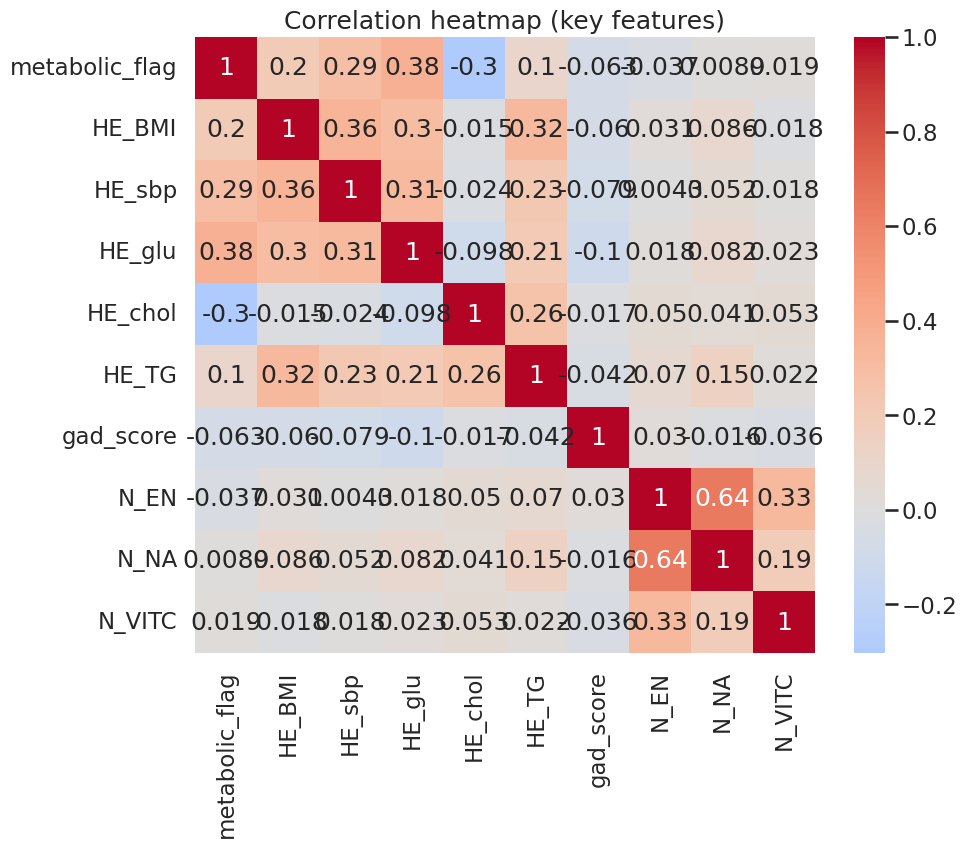

In [11]:
corr_cols = [
    "metabolic_flag",
    "HE_BMI",
    "HE_sbp",
    "HE_glu",
    "HE_chol",
    "HE_TG",
    "gad_score",
    "N_EN",
    "N_NA",
    "N_VITC",
]
corr_matrix = preprocessed_df[corr_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, center=0)
plt.title("Correlation heatmap (key features)")
plt.show()

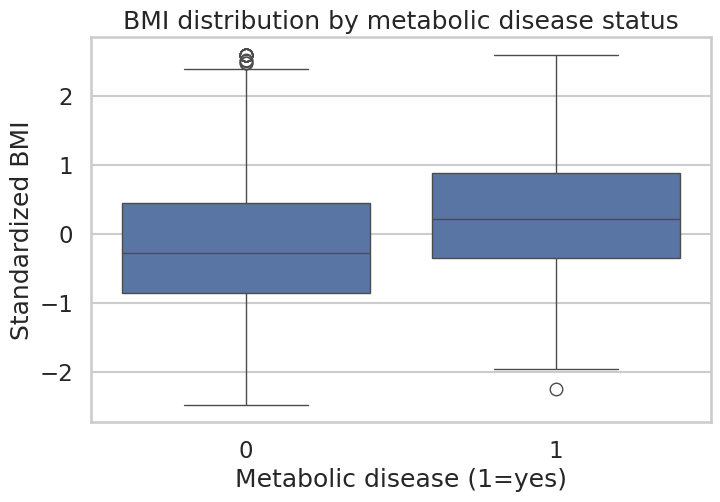

In [12]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=preprocessed_df, x="metabolic_flag", y="HE_BMI")
plt.xlabel("Metabolic disease (1=yes)")
plt.ylabel("Standardized BMI")
plt.title("BMI distribution by metabolic disease status")
plt.show()

In [13]:
pd.DataFrame.from_dict(scaler_stats, orient="index").head()

,mean,std
sex,1.750503,0.432722
age,47.885983,12.447950
HE_ht,162.320121,7.985504
HE_wt,62.889470,12.376333
HE_wc,81.591633,10.999284
